In [88]:
# Autoreload extension for Jupyter notebooks
%load_ext autoreload
%autoreload 2

# Manual reload
from importlib import reload

# Magic commands for inline plotting and high-res figures
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Standard library imports
import os
import sys
import pickle
from pprint import pprint

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
from tqdm import tqdm

# Custom modules (if needed)
# module_path = os.path.join(os.path.expanduser('~'), 'CustomModules')
# sys.path.append(module_path)
# from telegram_notify import notify
# from plotting_tools import error_band_plot, get_ax_data_range

# Add the parent directory to sys.path (if needed)
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent.parent))

# Other modules (if needed)
import src.color_code_stim as ccs

# Pandas and plotting configurations
pd.set_option('display.max_rows', 1000)
idx = pd.IndexSlice

jtplot.style(context='paper', theme='grade3', grid=False, ticks=True)
DFT_FIG_WIDTH_WIDE = 11
DFT_FIG_WIDTH = 5.3
COLORS = plt.get_cmap('tab10')
# Choose in ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 
# 'tab10', 'tab20', 'tab20b', 'tab20c']

# Utility functions
def write_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simulation

In [89]:
from joblib import Parallel, delayed


def simulate_color_code(
    d: int, p: float, shots: int
) -> tuple[tuple[int, float], np.ndarray]:
    """
    Simulate color code for given parameters.

    Parameters
    ----------
    d : int
        Distance parameter for the color code.
    p : float
        Bit flip probability.
    shots : int
        Number of simulation shots.

    Returns
    -------
    key : tuple of (int, float)
        The (d, p) parameter tuple.
    gaps : 1D numpy array of float
        Array of logical gaps with failures marked as negative values.
    """
    cc = ccs.ColorCode(
        d=d,
        rounds=1,
        p_bitflip=p,
        comparative_decoding=True,
        exclude_non_essential_pauli_detectors=True,
    )
    _, outputs = cc.simulate(shots, full_output=True)
    gaps = outputs["logical_gaps"].copy()
    fails = outputs["fails"]
    gaps[fails] *= -1
    return (d, p), gaps


shots = 100_000
d_min = 9
d_max = 19

# Create parameter combinations
param_combinations = [
    (d, p)
    for d in range(d_min, d_max + 1, 2)
    for p in np.arange(0.07, 0.111, 0.001).round(7)
]

# Run simulations in parallel
results = Parallel(n_jobs=9, verbose=10)(
    delayed(simulate_color_code)(d, p, shots) for d, p in param_combinations
)

# Convert results to dictionary
gap_data = dict(results)

[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done   7 tasks      | elapsed:    6.5s
[Parallel(n_jobs=9)]: Done  14 tasks      | elapsed:   10.9s
[Parallel(n_jobs=9)]: Done  23 tasks      | elapsed:   15.7s
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:   21.1s
[Parallel(n_jobs=9)]: Done  43 tasks      | elapsed:   29.0s
[Parallel(n_jobs=9)]: Done  54 tasks      | elapsed:   37.7s
[Parallel(n_jobs=9)]: Done  67 tasks      | elapsed:   52.2s
[Parallel(n_jobs=9)]: Done  80 tasks      | elapsed:  1.1min
[Parallel(n_jobs=9)]: Done  95 tasks      | elapsed:  1.4min
[Parallel(n_jobs=9)]: Done 110 tasks      | elapsed:  1.8min
[Parallel(n_jobs=9)]: Done 127 tasks      | elapsed:  2.3min
[Parallel(n_jobs=9)]: Done 144 tasks      | elapsed:  2.8min
[Parallel(n_jobs=9)]: Done 163 tasks      | elapsed:  3.6min
[Parallel(n_jobs=9)]: Done 182 tasks      | elapsed:  4.5min
[Parallel(n_jobs=9)]: Done 203 tasks      | elapsed:  5.6min
[Parallel(

In [90]:
write_pickle("gap_data.pkl", gap_data)

## Analysis

In [92]:
gap_data = read_pickle("gap_data.pkl")

In [96]:
d = [key[0] for key in gap_data.keys()]
p = [key[1] for key in gap_data.keys()]

print(min(d), max(d))
print(min(p), max(p))

9 19
0.07 0.11


### Logical failure rate fitting

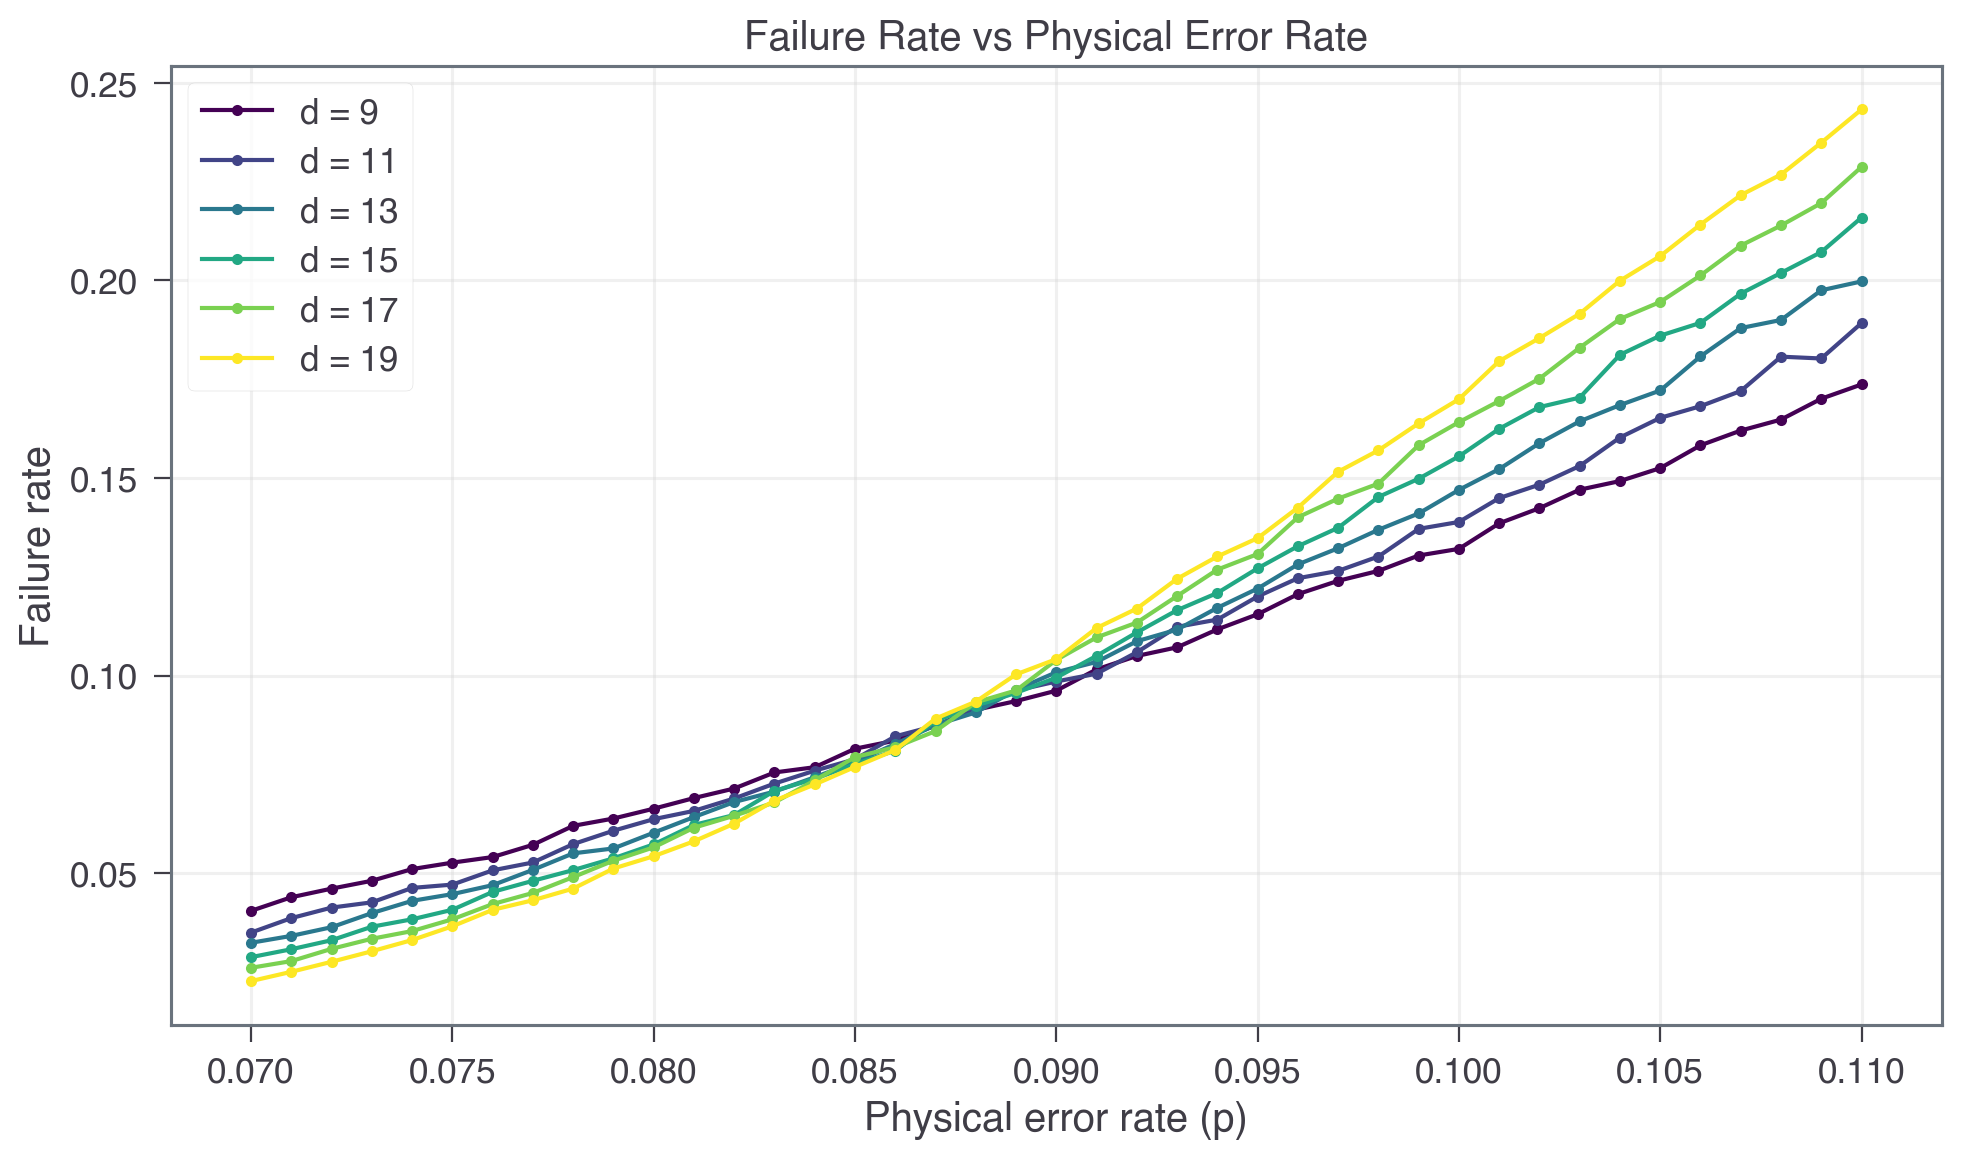

In [98]:
# Calculate failure rates for each (d, p) combination
failure_rates = {}

for (d, p), gaps in gap_data.items():
    # Count negative gaps (failures)
    n_failures = np.sum(np.array(gaps) < 0)
    n_total = len(gaps)
    failure_rate = n_failures / n_total

    if d not in failure_rates:
        failure_rates[d] = {"p_values": [], "rates": []}

    failure_rates[d]["p_values"].append(p)
    failure_rates[d]["rates"].append(failure_rate)

# Sort by p values for each d
for d in failure_rates:
    sorted_indices = np.argsort(failure_rates[d]["p_values"])
    failure_rates[d]["p_values"] = np.array(failure_rates[d]["p_values"])[
        sorted_indices
    ]
    failure_rates[d]["rates"] = np.array(failure_rates[d]["rates"])[sorted_indices]

# Plot failure rates vs p for each d
plt.figure(figsize=(10, 6))

# Get unique d values and create color map
d_values = sorted(failure_rates.keys())
colors = plt.cm.viridis(np.linspace(0, 1, len(d_values)))

for i, d in enumerate(d_values):
    plt.plot(
        failure_rates[d]["p_values"],
        failure_rates[d]["rates"],
        "o-",
        color=colors[i],
        label=f"d = {d}",
        markersize=4,
        linewidth=1.5,
    )

plt.xlabel("Physical error rate (p)")
plt.ylabel("Failure rate")
plt.title("Failure Rate vs Physical Error Rate")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Using p range [0.0766, 0.0968] for fitting
Number of data points: 120 out of 246 total
Fitted parameters:
A = 0.0861
B = 0.7410
C = 1.6898
nu = 1.4955
p_th = 0.0867


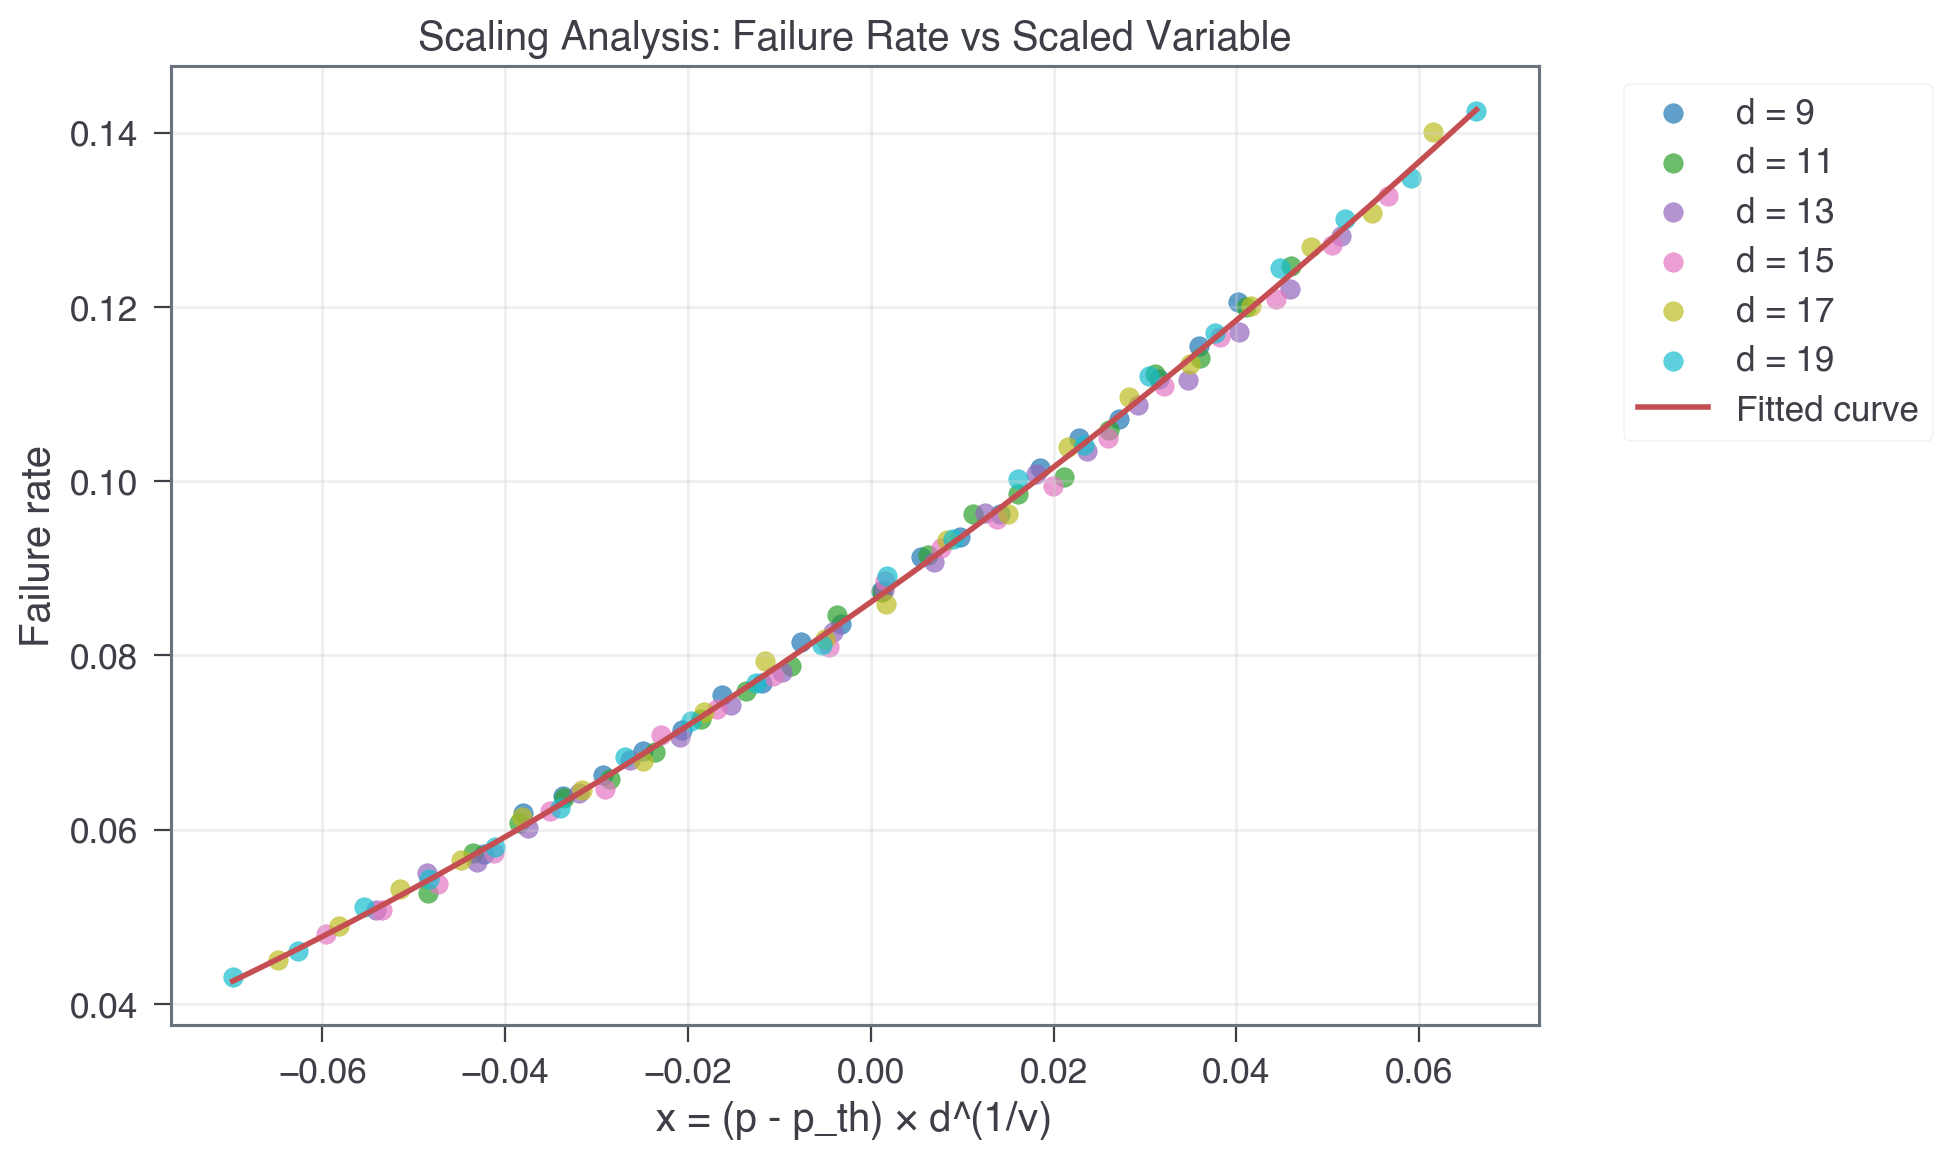

R-squared = 0.9985


In [119]:
from scipy.optimize import curve_fit

# Use the failure_rates dictionary calculated above
# Prepare data for scaling analysis
all_failure_data = []
for d in failure_rates:
    p_values = failure_rates[d]["p_values"]
    rates = failure_rates[d]["rates"]
    for p, rate in zip(p_values, rates):
        all_failure_data.append((d, p, rate))

# Convert to arrays for easier manipulation
all_failure_data = np.array(all_failure_data)
d_vals = all_failure_data[:, 0]
p_vals = all_failure_data[:, 1]
failure_vals = all_failure_data[:, 2]

# Option to filter data by p value range
use_p_range = True  # Set to True to use only specific p range
pth_approx = 0.0867
p_min = pth_approx - 0.0101  # Minimum p value to include
p_max = pth_approx + 0.0101  # Maximum p value to include

if use_p_range:
    # Filter data to only include p values in specified range
    mask = (p_vals >= p_min) & (p_vals <= p_max)
    d_vals_fit = d_vals[mask]
    p_vals_fit = p_vals[mask]
    failure_vals_fit = failure_vals[mask]
    print(f"Using p range [{p_min}, {p_max}] for fitting")
    print(f"Number of data points: {len(d_vals_fit)} out of {len(d_vals)} total")
else:
    # Use all data
    d_vals_fit = d_vals
    p_vals_fit = p_vals
    failure_vals_fit = failure_vals
    print("Using all data points for fitting")


# Define the scaling function for fitting
def scaling_fit_function(params, A, B, C, nu, p_th):
    """
    Scaling function for failure rate fitting.

    Parameters
    ----------
    params : 2D numpy array of float with shape (N, 2)
        Array where each row contains [d, p] values
    A : float
        Constant coefficient
    B : float
        Linear coefficient
    C : float
        Quadratic coefficient
    nu : float
        Critical exponent
    p_th : float
        Threshold probability

    Returns
    -------
    failure_rates : 1D numpy array of float
        Predicted failure rates
    """
    d_array = params[:, 0]
    p_array = params[:, 1]
    x = (p_array - p_th) * (d_array ** (1 / nu))
    return A + B * x + C * (x**2)


# Prepare parameter array for fitting (using filtered data)
param_array_fit = np.column_stack([d_vals_fit, p_vals_fit])

# Initial parameter guess
initial_guess = [0.5, -1.0, 0.1, 1.0, 0.1]  # [A, B, C, nu, p_th]

# Fit the scaling function
popt, pcov = curve_fit(
    lambda params, A, B, C, nu, p_th: scaling_fit_function(params, A, B, C, nu, p_th),
    param_array_fit,
    failure_vals_fit,
    p0=initial_guess,
    maxfev=5000,
)

A_fit, B_fit, C_fit, nu_fit, p_th_fit = popt

print(f"Fitted parameters:")
print(f"A = {A_fit:.4f}")
print(f"B = {B_fit:.4f}")
print(f"C = {C_fit:.4f}")
print(f"nu = {nu_fit:.4f}")
print(f"p_th = {p_th_fit:.4f}")

# Calculate x values for fitted data
x_fitted = (p_vals_fit - p_th_fit) * (d_vals_fit ** (1 / nu_fit))

# Create scatter plot with different colors for each distance
plt.figure(figsize=(10, 6))

# Get unique d values and create color map
unique_d_values = sorted(np.unique(d_vals_fit))
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_d_values)))
color_map = {d: colors[i] for i, d in enumerate(unique_d_values)}

# Plot fitted data points for each distance with different colors
for d in unique_d_values:
    mask_fit = d_vals_fit == d
    x_d_fit = x_fitted[mask_fit]
    failure_d_fit = failure_vals_fit[mask_fit]

    plt.scatter(
        x_d_fit,
        failure_d_fit,
        alpha=0.7,
        s=50,
        color=color_map[d],
        label=f"d = {int(d)}",
    )

# Create fitted line within the range of fitted data
x_range = np.linspace(np.min(x_fitted), np.max(x_fitted), 100)
y_fitted = A_fit + B_fit * x_range + C_fit * (x_range**2)
plt.plot(x_range, y_fitted, "r-", linewidth=2, label="Fitted curve")

plt.xlabel("x = (p - p_th) × d^(1/ν)")
plt.ylabel("Failure rate")
plt.title("Scaling Analysis: Failure Rate vs Scaled Variable")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate R-squared for fitted data
y_pred_fit = scaling_fit_function(
    param_array_fit, A_fit, B_fit, C_fit, nu_fit, p_th_fit
)
ss_res = np.sum((failure_vals_fit - y_pred_fit) ** 2)
ss_tot = np.sum((failure_vals_fit - np.mean(failure_vals_fit)) ** 2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R-squared = {r_squared:.4f}")

### Logical gap distribution

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

gap_data = read_pickle("gap_data.pkl")

# Collect statistics for each (d, p) combination
gap_stats = {}

for (d, p), gaps in gap_data.items():
    # Calculate mean and standard deviation
    llr_unit = np.log(1 - p) / np.log(p)
    gaps_rescaled = np.round(np.array(gaps) / llr_unit)
    mean_gap = np.mean(gaps)
    std_gap = np.std(gaps, ddof=1)  # Sample standard deviation

    # Store results
    gap_stats[(d, p)] = {
        "mean": mean_gap,
        "std": std_gap,
        "n_samples": len(gaps),
    }

Using 120 data points within p range [0.082, 0.102]
Fitted parameters:
a (quadratic): 4.134921
b (linear): -3.557632
c (constant): 1.237663
nu (critical exponent): 1.286490
p_th (threshold): 0.091610
R²: 0.994921


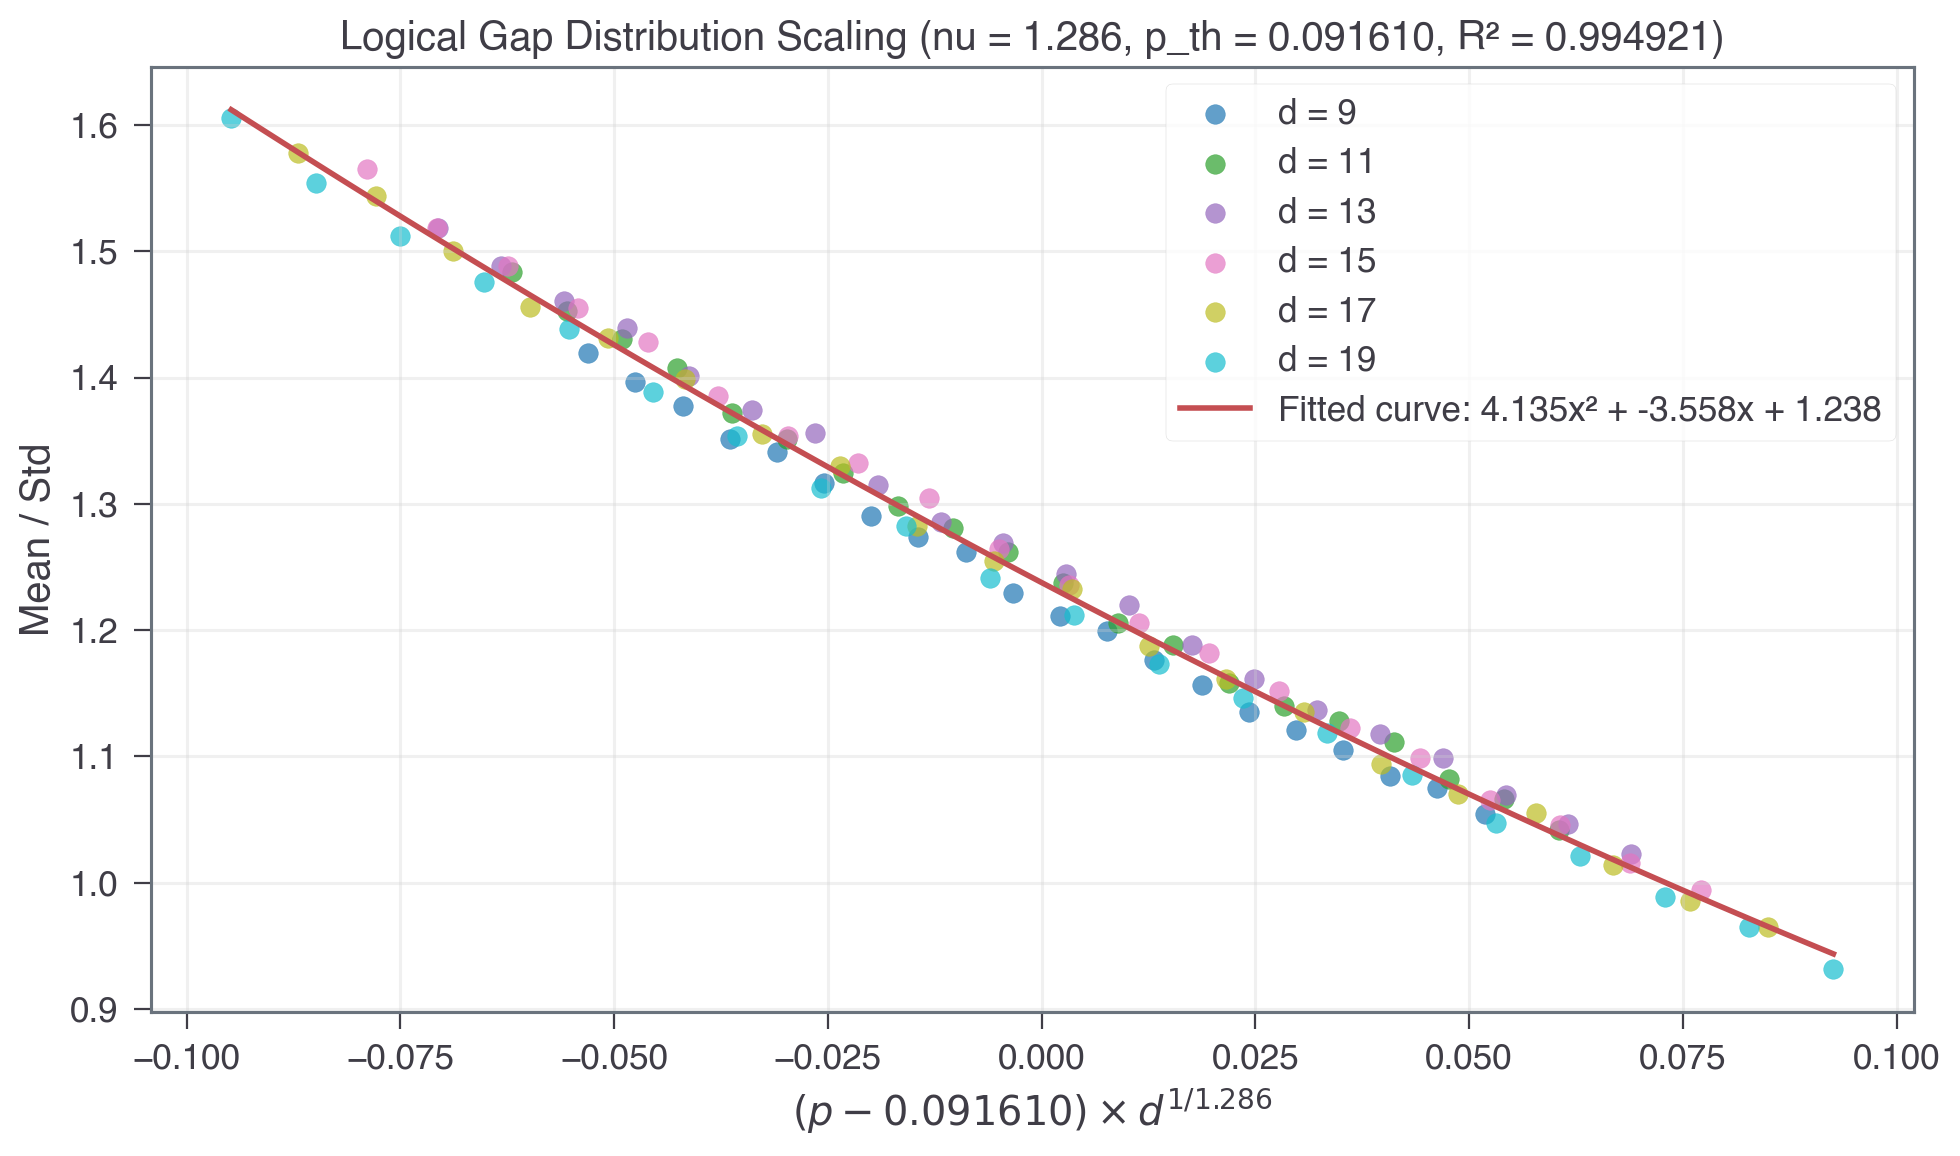

In [135]:
from scipy.optimize import curve_fit


def scaling_function(params, a, b, c, nu, p_th):
    """
    Scaling function for logical gap distribution.

    Parameters
    ----------
    params : 2D numpy array of float with shape (N, 2)
        Array where each row contains [d, p] values
    a : float
        Quadratic coefficient
    b : float
        Linear coefficient
    c : float
        Constant coefficient
    nu : float
        Critical exponent
    p_th : float
        Threshold probability

    Returns
    -------
    y_pred : 1D numpy array of float with shape (N,)
        Predicted mean/std values
    """
    d_values, p_values = params[:, 0], params[:, 1]
    x = (p_values - p_th) * (d_values ** (1 / nu))
    return a * x**2 + b * x + c


# Prepare data for curve fitting
params_array = []
y_values = []

d_min = 9
pth_guess = 0.091610  # Approximate threshold value
p_range = 0.0101  # Range around p_th_approx

for (d, p), stats_dict in gap_stats.items():
    if d < d_min:
        continue
    # Only include data points within the specified p range
    if abs(p - pth_guess) <= p_range:
        params_array.append([d, p])
        y_values.append(stats_dict["mean"] / stats_dict["std"])

params_array = np.array(params_array)
y_values = np.array(y_values)

print(
    f"Using {len(y_values)} data points within p range [{pth_guess - p_range:.3f}, {pth_guess + p_range:.3f}]"
)

# Initial parameter guesses
initial_guess = [0.1, 0.1, 0.1, 1.3, pth_guess]

# Fit the curve
popt, pcov = curve_fit(
    scaling_function,
    params_array,
    y_values,
    p0=initial_guess,
    bounds=(
        [-np.inf, -np.inf, -np.inf, 0, 0],  # Lower bounds
        [np.inf, np.inf, np.inf, np.inf, 1],  # Upper bounds
    ),
    # maxfev=10000,
)

a_fit, b_fit, c_fit, nu_fit, p_th_fit = popt

# Calculate R-squared
y_pred = scaling_function(params_array, *popt)
ss_res = np.sum((y_values - y_pred) ** 2)
ss_tot = np.sum((y_values - np.mean(y_values)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

print(f"Fitted parameters:")
print(f"a (quadratic): {a_fit:.6f}")
print(f"b (linear): {b_fit:.6f}")
print(f"c (constant): {c_fit:.6f}")
print(f"nu (critical exponent): {nu_fit:.6f}")
print(f"p_th (threshold): {p_th_fit:.6f}")
print(f"R²: {r_squared:.6f}")

# Calculate x values for plotting
d_values, p_values = params_array[:, 0], params_array[:, 1]
x_values = (p_values - p_th_fit) * (d_values ** (1 / nu_fit))

# Create the plot with different colors for d values
unique_d_values = np.unique(d_values)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_d_values)))

x_smooth = np.linspace(x_values.min(), x_values.max(), 100)
y_smooth = a_fit * x_smooth**2 + b_fit * x_smooth + c_fit

plt.figure(figsize=(10, 6))

# Plot data points with different colors for each d value
for i, d in enumerate(unique_d_values):
    mask = d_values == d
    plt.scatter(
        x_values[mask],
        y_values[mask],
        alpha=0.7,
        s=50,
        color=colors[i],
        label=f"d = {int(d)}",
    )

plt.plot(
    x_smooth,
    y_smooth,
    "r-",
    linewidth=2,
    label=f"Fitted curve: {a_fit:.3f}x² + {b_fit:.3f}x + {c_fit:.3f}",
)

plt.xlabel(rf"$(p - {p_th_fit:.6f}) \times d^{{1/{nu_fit:.3f}}}$")
plt.ylabel("Mean / Std")
plt.title(
    f"Logical Gap Distribution Scaling (nu = {nu_fit:.3f}, p_th = {p_th_fit:.6f}, R² = {r_squared:.6f})"
)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

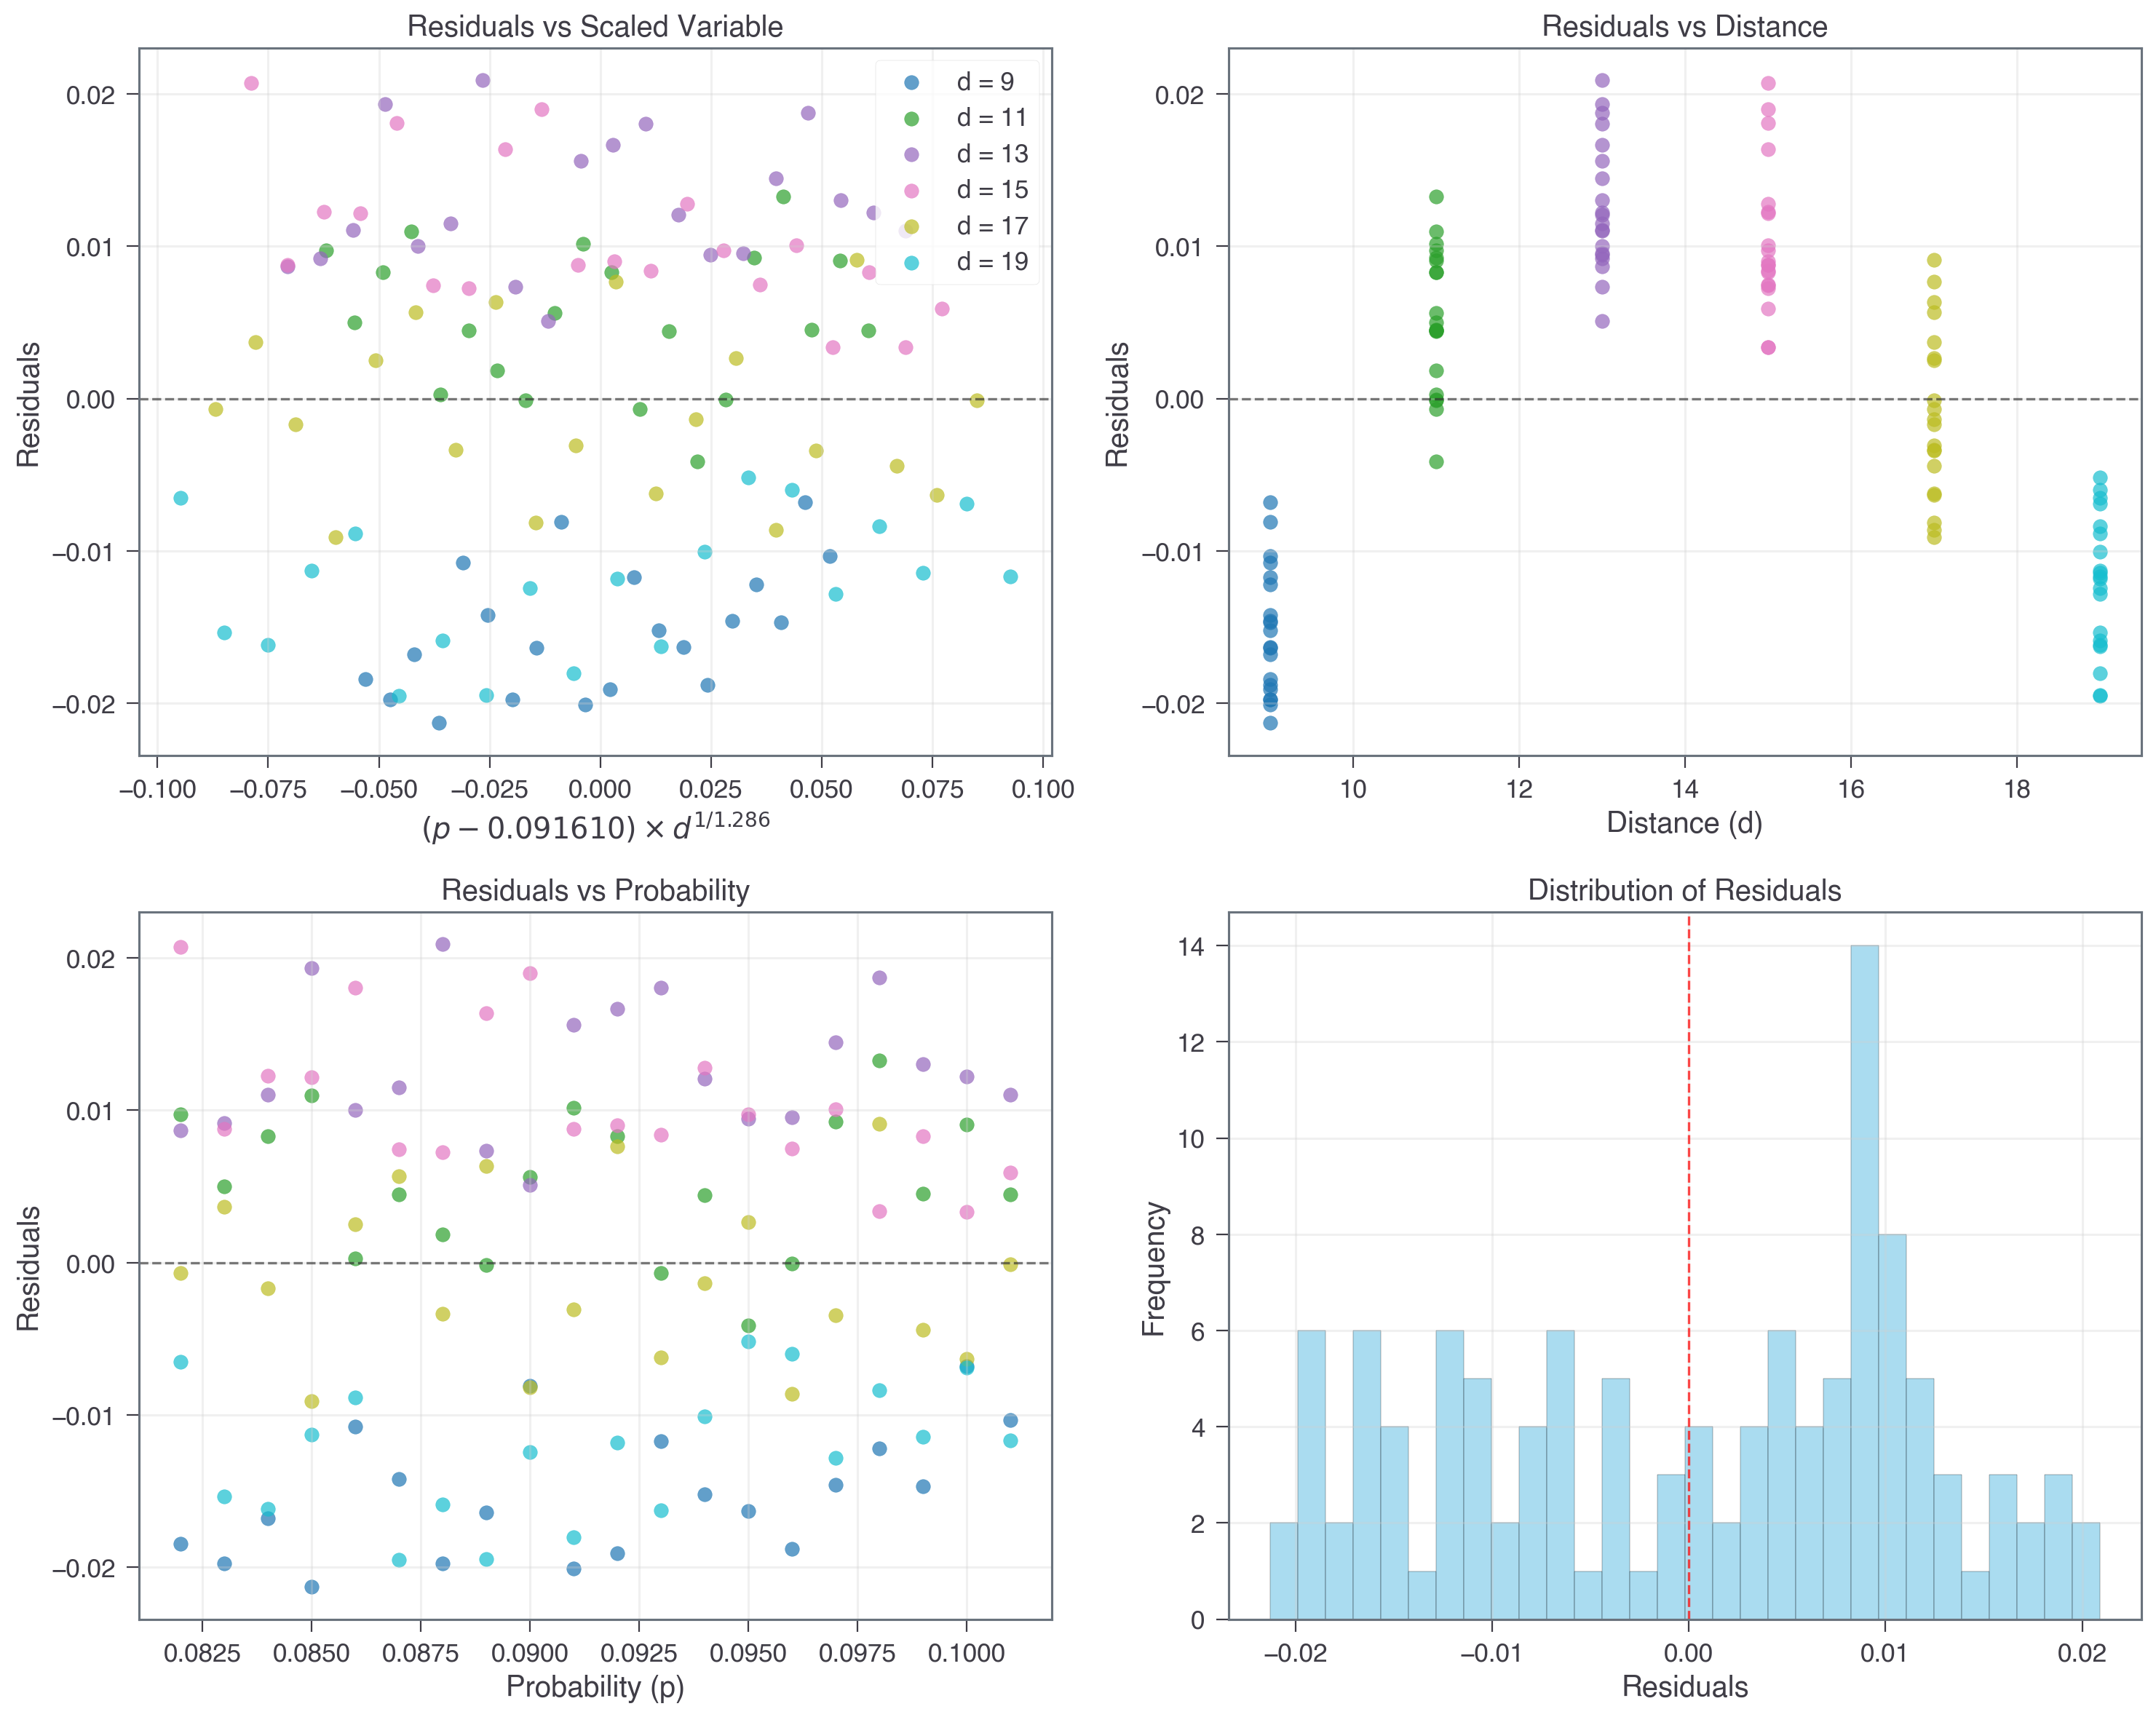


=== Residual Analysis ===
Mean residual: -0.000000
Std of residuals: 0.011589
Max absolute residual: 0.021290

=== Residuals by Distance ===
d = 9: mean = -0.015259, std = 0.004080
d = 11: mean = 0.005239, std = 0.004525
d = 13: mean = 0.012695, std = 0.004211
d = 15: mean = 0.010464, std = 0.004741
d = 17: mean = -0.000942, std = 0.005393
d = 19: mean = -0.012197, std = 0.004337

=== Correlations with Residuals ===
Correlation with d: -0.022996
Correlation with p: 0.006257
Correlation with scaled x: 0.000000


In [136]:
# Analyze residuals (deviations between fitted curve and actual data)
residuals = y_values - (a_fit * x_values**2 + b_fit * x_values + c_fit)

# Create subplots for residual analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Residuals vs x (scaled variable)
ax1 = axes[0, 0]
for i, d in enumerate(unique_d_values):
    mask = d_values == d
    ax1.scatter(
        x_values[mask],
        residuals[mask],
        alpha=0.7,
        s=50,
        color=colors[i],
        label=f"d = {int(d)}",
    )
ax1.axhline(y=0, color="black", linestyle="--", alpha=0.5)
ax1.set_xlabel(rf"$(p - {p_th_fit:.6f}) \times d^{{1/{nu_fit:.3f}}}$")
ax1.set_ylabel("Residuals")
ax1.set_title("Residuals vs Scaled Variable")
ax1.grid(True, alpha=0.3)
ax1.legend()

# 2. Residuals vs d (distance parameter)
ax2 = axes[0, 1]
for i, d in enumerate(unique_d_values):
    mask = d_values == d
    ax2.scatter(
        d_values[mask],
        residuals[mask],
        alpha=0.7,
        s=50,
        color=colors[i],
        label=f"d = {int(d)}",
    )
ax2.axhline(y=0, color="black", linestyle="--", alpha=0.5)
ax2.set_xlabel("Distance (d)")
ax2.set_ylabel("Residuals")
ax2.set_title("Residuals vs Distance")
ax2.grid(True, alpha=0.3)

# 3. Residuals vs p (probability parameter)
ax3 = axes[1, 0]
for i, d in enumerate(unique_d_values):
    mask = d_values == d
    ax3.scatter(
        p_values[mask],
        residuals[mask],
        alpha=0.7,
        s=50,
        color=colors[i],
        label=f"d = {int(d)}",
    )
ax3.axhline(y=0, color="black", linestyle="--", alpha=0.5)
ax3.set_xlabel("Probability (p)")
ax3.set_ylabel("Residuals")
ax3.set_title("Residuals vs Probability")
ax3.grid(True, alpha=0.3)

# 4. Histogram of residuals
ax4 = axes[1, 1]
ax4.hist(residuals, bins=30, alpha=0.7, color="skyblue", edgecolor="black")
ax4.axvline(x=0, color="red", linestyle="--", alpha=0.7)
ax4.set_xlabel("Residuals")
ax4.set_ylabel("Frequency")
ax4.set_title("Distribution of Residuals")
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and print residual statistics
print("\n=== Residual Analysis ===")
print(f"Mean residual: {np.mean(residuals):.6f}")
print(f"Std of residuals: {np.std(residuals):.6f}")
print(f"Max absolute residual: {np.max(np.abs(residuals)):.6f}")

# Analyze residuals by distance
print("\n=== Residuals by Distance ===")
for d in unique_d_values:
    mask = d_values == d
    d_residuals = residuals[mask]
    print(
        f"d = {int(d)}: mean = {np.mean(d_residuals):.6f}, std = {np.std(d_residuals):.6f}"
    )

# Calculate correlation between residuals and parameters
corr_residuals_d = np.corrcoef(residuals, d_values)[0, 1]
corr_residuals_p = np.corrcoef(residuals, p_values)[0, 1]
corr_residuals_x = np.corrcoef(residuals, x_values)[0, 1]

print(f"\n=== Correlations with Residuals ===")
print(f"Correlation with d: {corr_residuals_d:.6f}")
print(f"Correlation with p: {corr_residuals_p:.6f}")
print(f"Correlation with scaled x: {corr_residuals_x:.6f}")